In [0]:
!pip install fastai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")



### Custom head

In [0]:
from fastai.vision.learner import cnn_config

In [0]:
def create_head(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, nn.Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

def create_cnn_model(base_arch:Callable, nc:int, cut:Union[int,Callable]=None, pretrained:bool=True,
                     lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                     bn_final:bool=False, concat_pool:bool=True):
    "Create custom convnet architecture"
    body = create_body(base_arch, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, nc, lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final)
    else: head = custom_head
    return nn.Sequential(body, head)

def cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int,Callable]=None, pretrained:bool=True,
                lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, custom_head:Optional[nn.Module]=None,
                split_on:Optional[SplitFuncOrIdxList]=None, bn_final:bool=False, init=nn.init.kaiming_normal_,
                concat_pool:bool=True, **kwargs:Any)->Learner:
    "Build convnet style learner."
    meta = cnn_config(base_arch)
    model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
        bn_final=bn_final, concat_pool=concat_pool)
    learn = Learner(data, model, **kwargs)
    learn.split(split_on or meta['split'])
    if pretrained: learn.freeze()
    if init: apply_init(model[1], init)
    return learn

## Download data

In [0]:
def folder_download(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  for f in res['files']:
    if f['name'] == 'dataset-resized.zip':
      fid = f['id']
      !gdown -q --id $fid
  print('FINISHED')
  
from google.colab import auth

auth.authenticate_user()
folder_download('0B3P9oO5A3RvSUW9qTG11Ul83TEE')
!unzip dataset-resized.zip
!rm -rf __MACOSX
!rm -rf dataset-backup
!mkdir dataset-backup
!mv dataset-resized/trash dataset-backup/
!rm -rf dataset-resized/.DS_Store

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Training

In [0]:
#constants
bs = 64  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size
path = Path('dataset-resized')
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=sz, num_workers=4).normalize(imagenet_stats)

In [0]:
print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 1912 training images and 478 validation images.


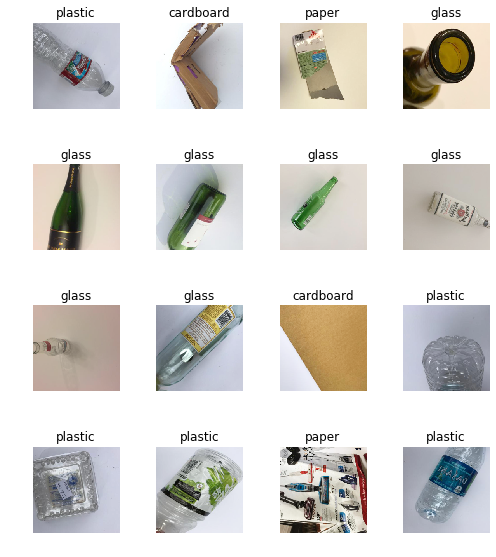

In [0]:
data.show_batch(rows=4, figsize=(7,8))

In [0]:
classes = data.classes

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 70.6MB/s]


In [0]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.340041,0.362188,0.106695,00:29
1,0.314570,0.314369,0.119247,00:30
2,0.322575,0.296798,0.110879,00:30
3,0.330070,0.329980,0.108787,00:29
4,0.307762,0.304016,0.106695,00:30
5,0.263498,0.260770,0.106695,00:30
6,0.233671,0.264875,0.102510,00:30
7,0.211801,0.254573,0.094142,00:30
8,0.188390,0.251044,0.087866,00:30
9,0.170833,0.243489,0.085774,00:30


In [0]:
learn.save('transfer-1')


In [0]:
learn.load('transfer-1')

Learner(data=ImageDataBunch;

Train: LabelList (1912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: dataset-resized;

Valid: LabelList (478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
glass,plastic,metal,plastic,metal
Path: dataset-resized;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mome

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


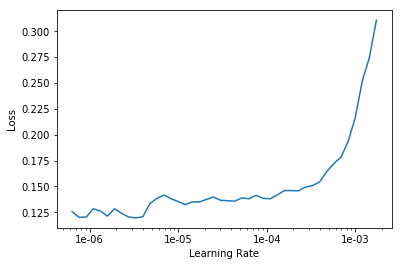

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(5e-5,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.146740,0.214745,0.081590,00:31
1,0.138607,0.223843,0.079498,00:31
2,0.169726,0.333310,0.096234,00:31
3,0.166187,0.283899,0.098326,00:31
4,0.132128,0.264359,0.073222,00:31
5,0.108906,0.219662,0.071130,00:31
6,0.078122,0.180873,0.052301,00:31
7,0.055669,0.182332,0.054393,00:31
8,0.046514,0.174536,0.058577,00:31
9,0.038591,0.175104,0.054393,00:31


In [0]:
learn.save('error_005')

In [0]:
!mkdir -p /content/drive/My\ Drive/trashnet

In [0]:
!cp dataset-resized/models/*.pth /content/drive/My\ Drive/trashnet/

In [0]:
x = torch.randn(1, 3, sz, sz, requires_grad=False).cuda()
torch_out = torch.onnx._export(learn.model, x, "trashnet-resnet34.onnx", export_params=True)

In [0]:
!cp trashnet-resnet34.onnx /content/drive/My\ Drive/trashnet/

### Load previous model


In [0]:
!ls /content/drive/My\ Drive/trashnet/

error_005.pth  tmp.pth	transfer-1.pth	trashnet-resnet34.onnx


In [0]:
learn.load('error_005')

In [0]:
model = learn.model.cpu()
model.eval()
example = torch.randn(1, 3, sz, sz)
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("model.pt")

In [0]:
!cp model.pt /content/drive/My\ Drive/trashnet/

## Load image

In [0]:
from PIL import Image
from torchvision import transforms

Prediction:  metal


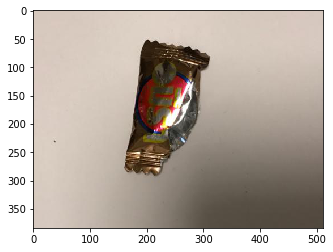

In [0]:
filename = 'dataset-backup/trash/trash10.jpg'
input_image = Image.open(filename)
plt.imshow(input_image)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(sz),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

model = learn.model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
#print(torch.nn.functional.softmax(output[0], dim=0))

index = output[0].data.cpu().numpy().argmax()
print('Prediction: ', classes[index])

In [0]:
!ls -al 

total 127188
drwxr-xr-x 1 root root     4096 Oct 18 14:19  .
drwxr-xr-x 1 root root     4096 Oct 18 12:25  ..
-rw-r--r-- 1 root root     2548 Oct 18 12:26  adc.json
drwxr-xr-x 1 root root     4096 Oct 18 12:26  .config
drwxr-xr-x 3 root root     4096 Oct 18 12:27  dataset-backup
drwxr-xr-x 8 root root     4096 Oct 18 12:52  dataset-resized
-rw-r--r-- 1 root root 42834870 Oct 18 12:27  dataset-resized.zip
drwx------ 3 root root     4096 Oct 18 14:15  drive
drwxr-xr-x 3 root root     4096 Oct 18 14:16 'My Drive'
drwxr-xr-x 1 root root     4096 Aug 27 16:17  sample_data
-rw-r--r-- 1 root root 87359012 Oct 18 14:19  trashnet-resnet34.onnx
